In [ ]:
!pip install CurrencyConverter
!pip install catboost
!pip install category_encoders
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from currency_converter import CurrencyConverter
from catboost import CatBoostRegressor
import category_encoders as ce
import seaborn as sns
c = CurrencyConverter(fallback_on_missing_rate=True)

In [ ]:
train_set = pd.read_csv(r'data/Train_TP2_Datos_2020-2C.csv')
test_set = pd.read_csv(r'data/Test_TP2_Datos_2020-2C.csv')

train_set = train_set[train_set["Stage"].str.contains("Closed")]

In [ ]:
#Armo Target y limpio columnas

train_set = train_set.drop(columns=["Sales_Contract_No", "Opportunity_Name", "Last_Modified_By", "Billing_Country", "ID", "Prod_Category_A", "Actual_Delivery_Date" ])
test_set = test_set.drop(columns=["Sales_Contract_No", "Opportunity_Name", "Last_Modified_By", "Billing_Country", "ID", "Prod_Category_A" , "Actual_Delivery_Date" ])

train_set['Last_Modified_Date']=pd.to_datetime(train_set['Last_Modified_Date'])
test_set['Last_Modified_Date']=pd.to_datetime(test_set['Last_Modified_Date'])

In [ ]:
#PROCESO COLUMNAS DE TIEMPOS, FECHAS Y PRECIOS

train_set["Opportunity_Created_Date"] = pd.to_datetime(train_set["Opportunity_Created_Date"], errors="coerce")
train_set["Account_Created_Date"] = pd.to_datetime(train_set["Account_Created_Date"], errors="coerce")
train_set["Quote_Expiry_Date"] = pd.to_datetime(train_set["Quote_Expiry_Date"], errors="coerce")
train_set["Last_Modified_Date"] = pd.to_datetime(train_set["Last_Modified_Date"], errors="coerce")

train_set['Total_Taxable_Amount_(converted)']= train_set.apply(lambda x: c.convert(x.Total_Taxable_Amount, x.Total_Taxable_Amount_Currency, 'USD', date=x.Last_Modified_Date), axis=1)

train_set["Planned_Delivery_Start_Date"] = pd.to_datetime(train_set["Planned_Delivery_Start_Date"], errors="coerce")
train_set["Planned_Delivery_End_Date"] = pd.to_datetime(train_set["Planned_Delivery_End_Date"], errors="coerce")
delay = train_set['Planned_Delivery_Start_Date'].sub(train_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
train_set["Delivery_Delay"] = [x if x > 0 else 0 for x in delay]


duracionPresupuesto = train_set['Quote_Expiry_Date'].sub(train_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
train_set["duracionPresupuesto"] = [x if x > 0 else 0 for x in duracionPresupuesto]

duration = train_set['Last_Modified_Date'].sub(train_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
train_set["duration"] = [x if x > 0 else 0 for x in duration]

timeInSystem = np.floor(train_set["Opportunity_Created_Date"].sub(train_set["Account_Created_Date"], axis=0)/ np.timedelta64(1, 'D'))
train_set["timeInSystem"] = [x if x > 0 else 0 for x in timeInSystem]

fromDate1 = min(train_set['Opportunity_Created_Date'])
fromDate2 = min(train_set['Last_Modified_Date'])
fromDate3 = min(train_set['Account_Created_Date'])

train_set['Opportunity_Created_Date_delta'] = (train_set["Opportunity_Created_Date"] - fromDate1).dt.days.astype(int)

train_set.drop(columns= ["Submitted_for_Approval", "Opportunity_Created_Date", "Total_Amount",\
                         'Pricing, Delivery_Terms_Approved', 'Pricing, Delivery_Terms_Quote_Appr',\
                         'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved',\
                         "Planned_Delivery_Start_Date","Planned_Delivery_End_Date", \
                         "Quote_Expiry_Date", "Last_Modified_Date", "Account_Created_Date", "Total_Taxable_Amount_Currency", \
                        "Total_Taxable_Amount", "ASP", "ASP_(converted)_Currency", \
                        "ASP_Currency", "Currency"], inplace = True)

#-----------------------------------------------
#-----------------------------------------------
#-----------------------------------------------
#-----------------------------------------------


test_set["Opportunity_Created_Date"] = pd.to_datetime(test_set["Opportunity_Created_Date"], errors="coerce")
test_set["Account_Created_Date"] = pd.to_datetime(test_set["Account_Created_Date"], errors="coerce")
test_set["Quote_Expiry_Date"] = pd.to_datetime(test_set["Quote_Expiry_Date"], errors="coerce")
test_set["Last_Modified_Date"] = pd.to_datetime(test_set["Last_Modified_Date"], errors="coerce")

test_set['Total_Taxable_Amount_(converted)']= test_set.apply(lambda x: c.convert(x.Total_Taxable_Amount, x.Total_Taxable_Amount_Currency, 'USD', date=x.Last_Modified_Date), axis=1)

test_set["Planned_Delivery_Start_Date"] = pd.to_datetime(test_set["Planned_Delivery_Start_Date"], errors="coerce")
test_set["Planned_Delivery_End_Date"] = pd.to_datetime(test_set["Planned_Delivery_End_Date"], errors="coerce")
delay = test_set['Planned_Delivery_Start_Date'].sub(test_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
test_set["Delivery_Delay"] = [x if x > 0 else 0 for x in delay]

duracionPresupuesto = test_set['Quote_Expiry_Date'].sub(test_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
test_set["duracionPresupuesto"] = [x if x > 0 else 0 for x in duracionPresupuesto]

duration = test_set['Last_Modified_Date'].sub(test_set['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
test_set["duration"] = [x if x > 0 else 0 for x in duration]

timeInSystem = np.floor(test_set["Opportunity_Created_Date"].sub(test_set["Account_Created_Date"], axis=0)/ np.timedelta64(1, 'D'))
test_set["timeInSystem"] = [x if x > 0 else 0 for x in timeInSystem]

test_set['Opportunity_Created_Date_delta'] = (test_set["Opportunity_Created_Date"] - fromDate1).dt.days.astype("int64")

test_set.drop(columns= [ "Submitted_for_Approval", "Opportunity_Created_Date", "Total_Amount",\
                        'Pricing, Delivery_Terms_Approved', 'Pricing, Delivery_Terms_Quote_Appr',\
                        'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved', \
                        "Planned_Delivery_Start_Date","Planned_Delivery_End_Date", \
                         "Quote_Expiry_Date", "Last_Modified_Date", "Account_Created_Date", "Total_Taxable_Amount_Currency", \
                        "Total_Taxable_Amount", "ASP", "ASP_(converted)_Currency", \
                        "ASP_Currency", "Currency"], inplace = True)

In [ ]:
#Agrupo por opportunity
aux1 = train_set.groupby(["Opportunity_ID"]).agg({"Territory": "count", "ASP_(converted)": ["sum", "mean"], "TRF": ["sum", "mean"]}).reset_index()
aux2 = test_set.groupby(["Opportunity_ID"]).agg({"Territory": "count", "ASP_(converted)": ["sum", "mean"], "TRF": ["sum", "mean"]}).reset_index()

aux1.columns = ["Opportunity_ID", "Products_Quantity", "ASP sum", "ASP mean",  "Total TRF", "TRF mean"]
aux2.columns = ["Opportunity_ID", "Products_Quantity", "ASP sum", "ASP mean", "Total TRF", "TRF mean"]
train_set = train_set.drop_duplicates(subset="Opportunity_ID")
test_set = test_set.drop_duplicates(subset="Opportunity_ID")

train_set = train_set.merge(aux1, on="Opportunity_ID")
test_set = test_set.merge(aux2, on="Opportunity_ID")

opps = train_set.groupby(["Account_Name"]).agg({"Territory":"count"}).reset_index()
opps.columns=["Account_Name", "Total Opportunities"]
train_set.merge(opps,on="Account_Name", how="right")

train_set = train_set.drop(columns=["TRF", "ASP_(converted)", "Products_Quantity"])
test_set = test_set.drop(columns=["TRF", "ASP_(converted)", "Products_Quantity"])


In [ ]:
#Proceso las columnas categoricas

from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

def crearLista (listadoCompleto):
    listaReducida = []
    for i in listadoCompleto:
        if i not in listaReducida:
            listaReducida.append(i)
    listaReducida.sort()
    return listaReducida

def discretizar(columna,nombre, df):
    listaReducida = crearLista(columna)
    v = list(range(len(columna)))
    listaCompleta = list(columna)
    for i in listaReducida:
        for j in range(len(listaCompleta)):
            if(listaCompleta[j] == i):
                v[j] = 1
            else:
                v[j] = 0
        df[nombre+str(i)] = v


train_set = train_set.sort_values(by=["Opportunity_Created_Date_delta"], ascending=True)
#MEAN
stage_train = train_set.Stage
train_set["Targetx"] = [1 if x == "Closed Won" else 0 for x in stage_train]

target_enc1 = ce.TargetEncoder(train_set["Region"])
target_enc1.fit(train_set["Region"], train_set["Targetx"])
train_set = train_set.join(target_enc1.transform(train_set["Region"]), rsuffix="_target")

target_enc3 = ce.TargetEncoder(train_set["Opportunity_Owner"])
target_enc3.fit(train_set["Opportunity_Owner"], train_set["Targetx"])
train_set = train_set.join(target_enc3.transform(train_set["Opportunity_Owner"]), rsuffix="_target")

target_enc4 = ce.TargetEncoder(train_set["Account_Owner"])
target_enc4.fit(train_set["Account_Owner"], train_set["Targetx"])
train_set = train_set.join(target_enc4.transform(train_set["Account_Owner"]), rsuffix="_target")

stage_train = train_set.Stage
train_set["Target"] = [1 if x == "Closed Won" else 0 for x in stage_train]
train_set = train_set.drop(columns=["Stage"])
train_set = train_set.fillna(0)

train_set = train_set.drop(columns=["Opportunity_ID","Delivery_Year", "duracionPresupuesto", "Targetx"])

toTrain = train_set.select_dtypes("number")

#-----------------------------------------------------------
#-----------------------------------------------------------
#-----------------------------------------------------------
#-----------------------------------------------------------
#-----------------------------------------------------------

test_set = test_set.join(target_enc1.transform(test_set["Region"]), rsuffix="_target")
test_set = test_set.join(target_enc3.transform(test_set["Opportunity_Owner"]), rsuffix="_target")
test_set = test_set.join(target_enc4.transform(test_set["Account_Owner"]), rsuffix="_target")

test_set = test_set.fillna(0)
test_set = test_set.sort_values(by=["Opportunity_Created_Date_delta"], ascending=True)
ids = test_set["Opportunity_ID"]
test_set = test_set.drop(columns=["Opportunity_ID", "Delivery_Year", "duracionPresupuesto"])

toTest = test_set.select_dtypes("number")

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
X, y = toTrain.iloc[:,:-1],toTrain.iloc[:,-1]

X_train = X.iloc[:8421]
X_test = X.iloc[8421:]

y_train = y.iloc[:8421]
y_test = y.iloc[8421:]


# Random Forest Regressor

In [ ]:
rmse = 0
hp = (14, 5, 9, 2)
rf_model = RandomForestRegressor(n_estimators= 96, max_depth = hp[0], min_samples_split= hp[1], min_samples_leaf= hp[2], max_features=hp[3])
rf_model.fit(X_train, y_train)
preds1 = rf_model.predict(X_test)
print("LOG LOSS:", log_loss(y_test, preds1))
print(max(preds1))
print(min(preds1))

LOG LOSS: 0.44758118931404084
0.986339610451361
0.040320482000224825


In [ ]:
best = 1
a = [13, 14]
for i in a:
    for j in range(2, 5):
            print(i, j)
            for k in range(2, 7):
                for r in range(2, 3):
                    rmse = 0
                    for s in range(2):
                        rf_model = RandomForestRegressor(n_estimators= 98, max_depth = i, min_samples_split= j, min_samples_leaf= k, max_features=r)
                        rf_model.fit(X_train, y_train)
                        preds = rf_model.predict(X_test)
                        rmse = rmse + log_loss(y_test, preds)
                    rmse = rmse/2
                    if (rmse < best):
                        best = rmse
                        print(best, (i, j, k, r))
                        best_tuple = (i, j, k, r)
print("RMSE: %f" % (best))
print(best_tuple)

In [ ]:
hp = (98, 5, 8, 2)

rf_model = RandomForestRegressor(n_estimators= hp[0], max_depth = 15, min_samples_split= hp[1], min_samples_leaf= hp[2], max_features=hp[3])
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
print("LOG LOSS:", log_loss(y_test, preds))


LOG LOSS: 0.45002488187887507


In [ ]:
predsRF = rf_model.predict(toTest)

predict_df = pd.DataFrame(data=ids)

predict_df["Target"] = predsRF

predict_df.head()

In [ ]:
predict_df.to_csv("resultado.csv",index=False) 

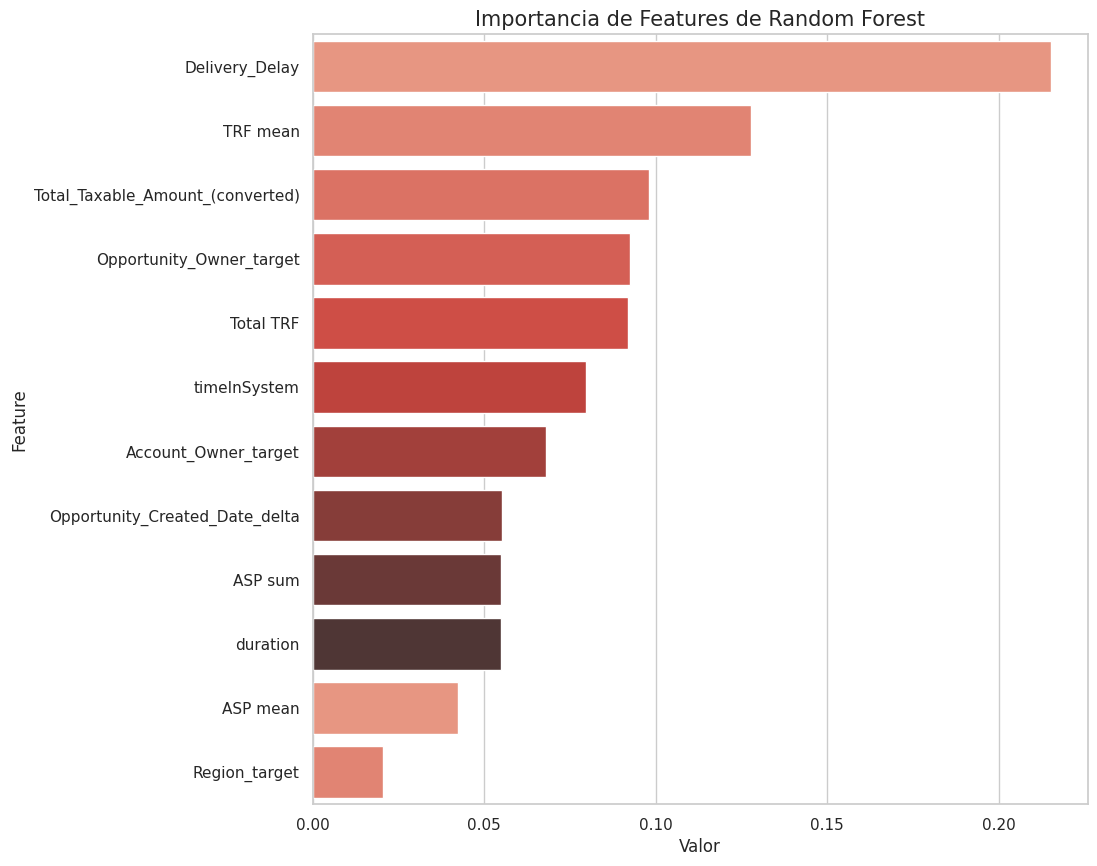

In [ ]:
features = pd.DataFrame(index=X.columns)
features['imp'] = rf_model.feature_importances_
features = features.sort_values(['imp'], ascending = False)
features

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 10)
sns.set(style="whitegrid")

g = sns.barplot(y=features.index, x=features.imp, \
                palette=sns.color_palette("Reds_d", 10));

g.set_title('Importancia de Features de Random Forest', fontsize=15);
g.set_xlabel('Valor');
g.set_ylabel('Feature');

# XGBoost

In [ ]:
!pip install xgboost
import xgboost as xgb

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', 
colsample_bytree = 0.5, learning_rate = 0.1,
max_depth = 30, alpha = 1.3, gamma = 0.15, n_estimators = 100)
xg_reg.fit(X,y)
preds2 = xg_reg.predict(toTest)

xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = log_loss(y_test, preds)

print(max(preds2), min(preds2))

0.99883085 0.0018545549


In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

params = {"objective":"reg:logistic",'colsample_bytree': 0.3,
          'learning_rate': 0.15, "colsample_bytree": 0.43, 'max_depth': 20, 'alpha': 1.6}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=20,
                    num_boost_round=100, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=123)
print((cv_results["test-rmse-mean"]).tail(1))

83    0.334916
Name: test-rmse-mean, dtype: float64


In [ ]:
ops = ids
out = pd.DataFrame()
out["Opportunity_ID"] = ops
out["Target"] = preds2

out.to_csv(r"results.csv")

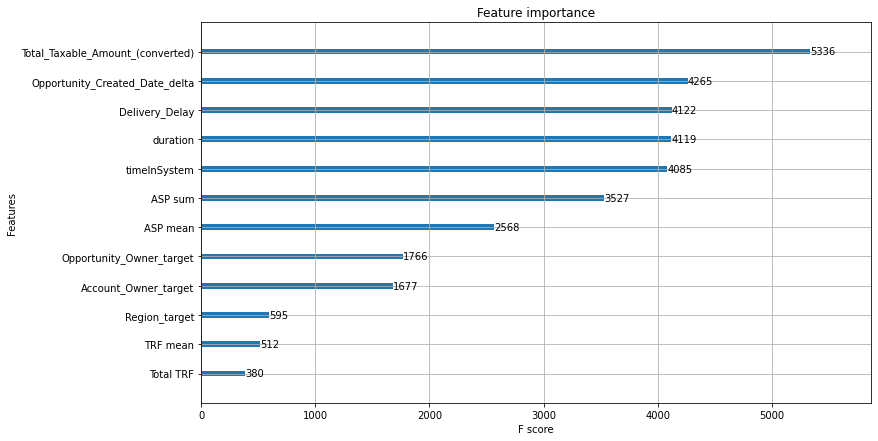

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

# Grid Search & Random Search - Catboost Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV

### Random Search

In [ ]:
grid = {'learning_rate': [0.03, 0.1, 0.3],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

model = CatBoostRegressor()

randomized_search_result = model.randomized_search(grid, X=X_train, y=y_train, plot=False)

### Grid Search

In [ ]:
parameters = {'depth': [7,8,9], 'learning_rate' : [0.08, 0.09, 0.1, 0.12, 0.15, 0.2],'iterations': [50, 100, 120]}

model = CatBoostRegressor()

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)

grid.fit(X_train, y_train)

In [ ]:
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

In [ ]:
# Catboost regresor (Usando parámetros de Grid Search)

model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=7)

model.fit(X_train,y_train)

preds = model.predict(X_test)

logloss = log_loss(y_test, preds)
print("Log loss: {:.2f}".format(logloss))

In [ ]:
import seaborn as sns

In [ ]:
X.columns

Index(['Total_Taxable_Amount_(converted)', 'Delivery_Delay', 'duration',
       'timeInSystem', 'Opportunity_Created_Date_delta', 'ASP sum', 'ASP mean',
       'Total TRF', 'TRF mean', 'Region_target', 'Opportunity_Owner_target',
       'Account_Owner_target'],
      dtype='object')

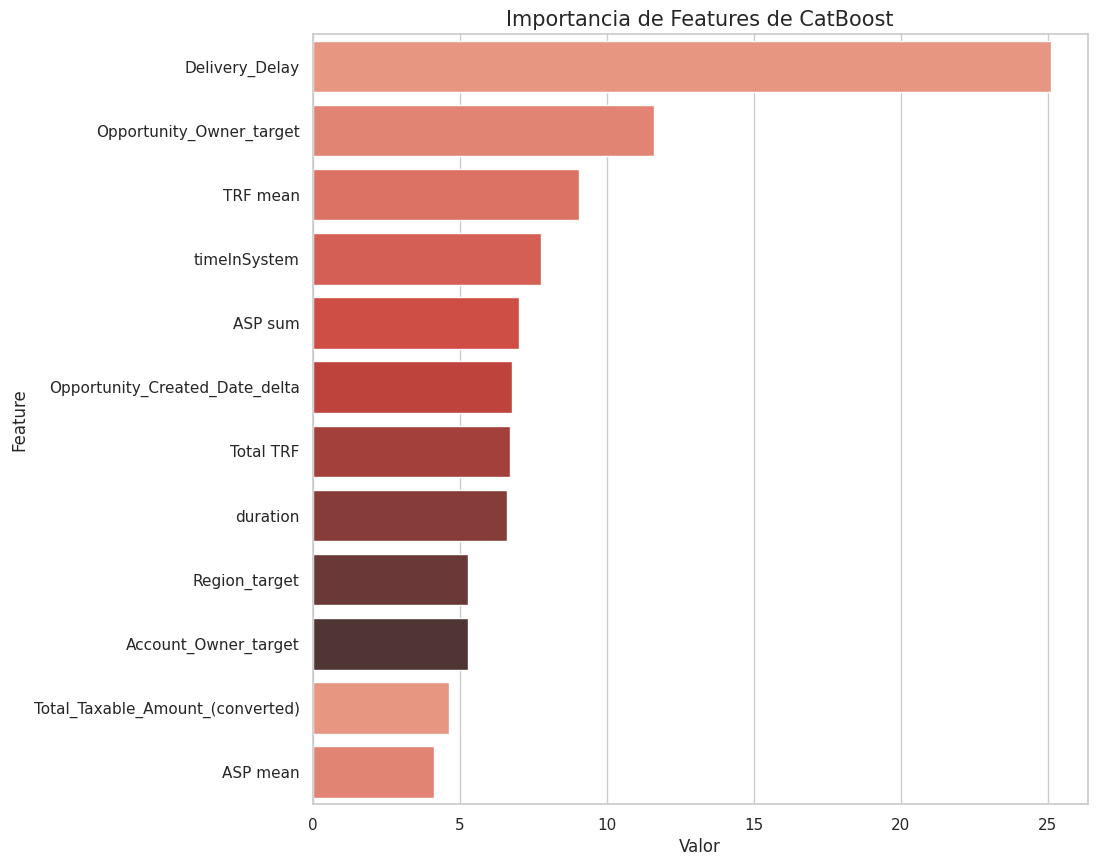

In [ ]:
features = pd.DataFrame(index=X.columns)
features['imp'] = model.feature_importances_
features = features.sort_values(['imp'], ascending = False)
features

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 10)
sns.set(style="whitegrid")

g = sns.barplot(y=features.index, x=features.imp, \
                palette=sns.color_palette("Reds_d", 10));

g.set_title('Importancia de Features de CatBoost', fontsize=15);
g.set_xlabel('Valor');
g.set_ylabel('Feature');

In [ ]:
model.fit(X, y)
preds = model.predict(toTest)

In [ ]:
len(preds)

In [ ]:
predict_df = pd.DataFrame(data=ids)

predict_df["Target"] = preds

predict_df.head()

,Opportunity_ID,Target
423,11223,0.994957
422,11222,0.788138
424,11224,0.966119
425,11225,0.511207
426,11226,0.673455


In [ ]:
predict_df.to_csv("resultado.csv",index=False) 

# Set de datos reducido

In [ ]:
duration = train_set["duration"]
tys = train_set["timeInSystem"]
deliveryDelay = train_set["Delivery_Delay"]
ttac = train_set["Total_Taxable_Amount_(converted)"]
ocd = train_set["Opportunity_Created_Date_delta"]
ttrf = train_set["Total TRF"]
trfm = train_set["TRF mean"]
asps = train_set["ASP sum"]

duration1 = test_set["duration"]
tys1 = test_set["timeInSystem"]
deliveryDelay1 = test_set["Delivery_Delay"]
ttac1 = test_set["Total_Taxable_Amount_(converted)"]
ocd1 = test_set["Opportunity_Created_Date_delta"]
ttrf1 = test_set["Total TRF"]
trfm1 = test_set["TRF mean"]
asps1 = test_set["ASP sum"]

y = train_set["Target"]


X = pd.DataFrame(duration)
X = X.join(tys)

X = X.join(ttrf)
X = X.join(trfm)
X = X.join(deliveryDelay)
X = X.join(ttac)
X = X.join(ocd)


toTest = pd.DataFrame(duration1)
toTest = toTest.join(tys1)

toTest = toTest.join(ttrf1)
toTest = toTest.join(trfm1)
toTest = toTest.join(deliveryDelay1)
toTest = toTest.join(ttac1)
toTest = toTest.join(ocd1)

Xs, ys = X.iloc[:,:-1],X.iloc[:,-1]

X_train = X.iloc[:8421]
X_test = X.iloc[8421:]

y_train = y.iloc[:8421]
y_test = y.iloc[8421:]

# CatBoost Grid Search para set reducido

In [ ]:
parameters = {'depth': [7,8,9], 'learning_rate' : [0.07, 0.08, 0.09, 0.1, 0.12],'iterations': [30, 40, 50, 60, 100, 120]}

model = CatBoostRegressor()

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)

grid.fit(X_train, y_train)

In [ ]:
print("\n The best parameters across ALL searched params:\n", grid.best_params_)


 The best parameters across ALL searched params:
 {'depth': 7, 'iterations': 40, 'learning_rate': 0.09}


In [ ]:
print("\n The best score across ALL searched params:\n", grid.best_score_)


 The best score across ALL searched params:
 0.3382677417764442


In [ ]:
# Catboost regresor (Usando parámetros de Grid Search)

model = CatBoostRegressor(iterations=40, learning_rate=0.09, depth=7)

model.fit(X_train,y_train)

preds = model.predict(X_test)

logloss = log_loss(y_test, preds)
print("Log loss: {:.2f}".format(logloss))

In [ ]:
model.fit(X, y)
preds = model.predict(toTest)

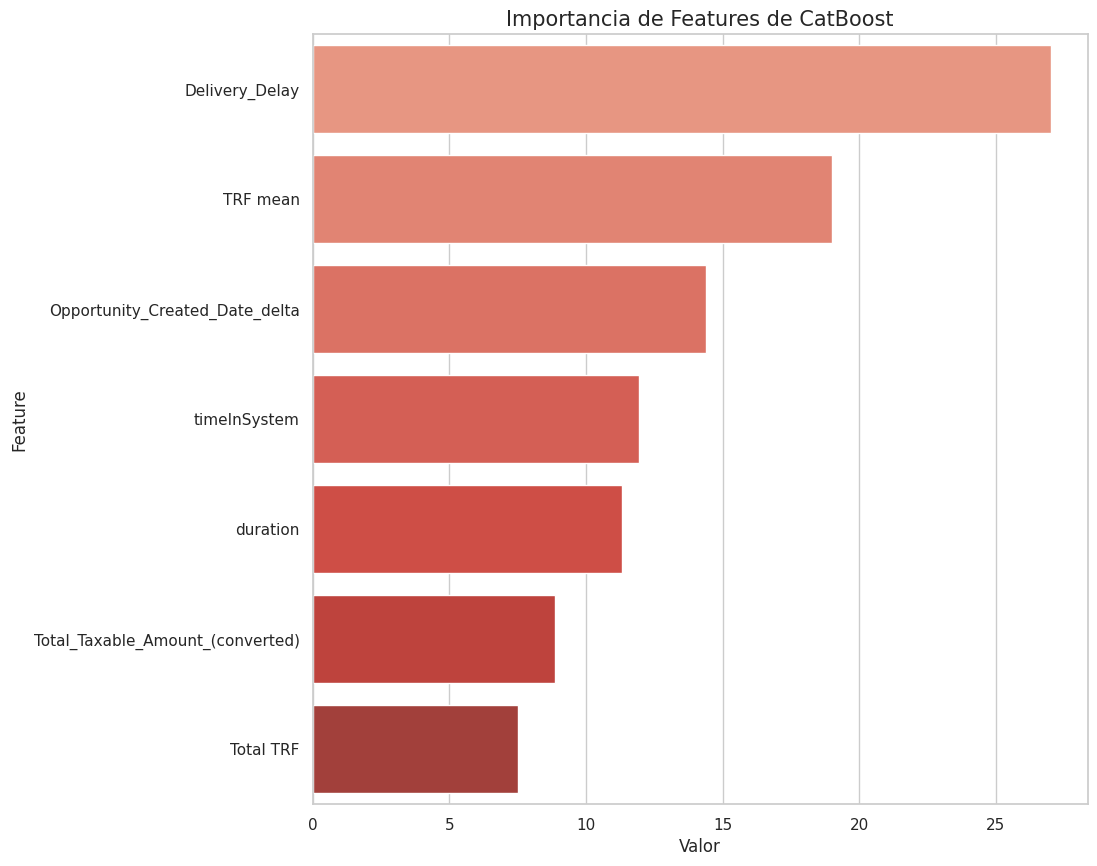

In [ ]:
# Feature importance Set reducido
features = pd.DataFrame(index=X.columns)
features['imp'] = model.feature_importances_
features = features.sort_values(['imp'], ascending = False)
features

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 10)
sns.set(style="whitegrid")

g = sns.barplot(y=features.index, x=features.imp, \
                palette=sns.color_palette("Reds_d", 10));

g.set_title('Importancia de Features de CatBoost', fontsize=15);
g.set_xlabel('Valor');
g.set_ylabel('Feature');

In [ ]:
predict_df = pd.DataFrame(data=ids)

predict_df["Target"] = preds

predict_df.head()

In [ ]:
predict_df.to_csv("resultadoSetReducido.csv",index=False)

# Random Forest para set reducido

In [ ]:
hp = (98, 5, 8, 2)

rf_model = RandomForestRegressor(n_estimators= hp[0], max_depth = 15, min_samples_split= hp[1], min_samples_leaf= hp[2], max_features=hp[3])
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
print("LOG LOSS:", log_loss(y_test, preds))


LOG LOSS: 0.45797828474293606


In [ ]:
predsRF = rf_model.predict(toTest)

predict_df = pd.DataFrame(data=ids)

predict_df["Target"] = predsRF

predict_df.head()

,Opportunity_ID,Target
423,11223,0.533289
422,11222,0.890009
424,11224,0.523707
425,11225,0.643797
426,11226,0.491670


In [ ]:
predict_df.to_csv("resultadoRF-Reducido.csv",index=False) 

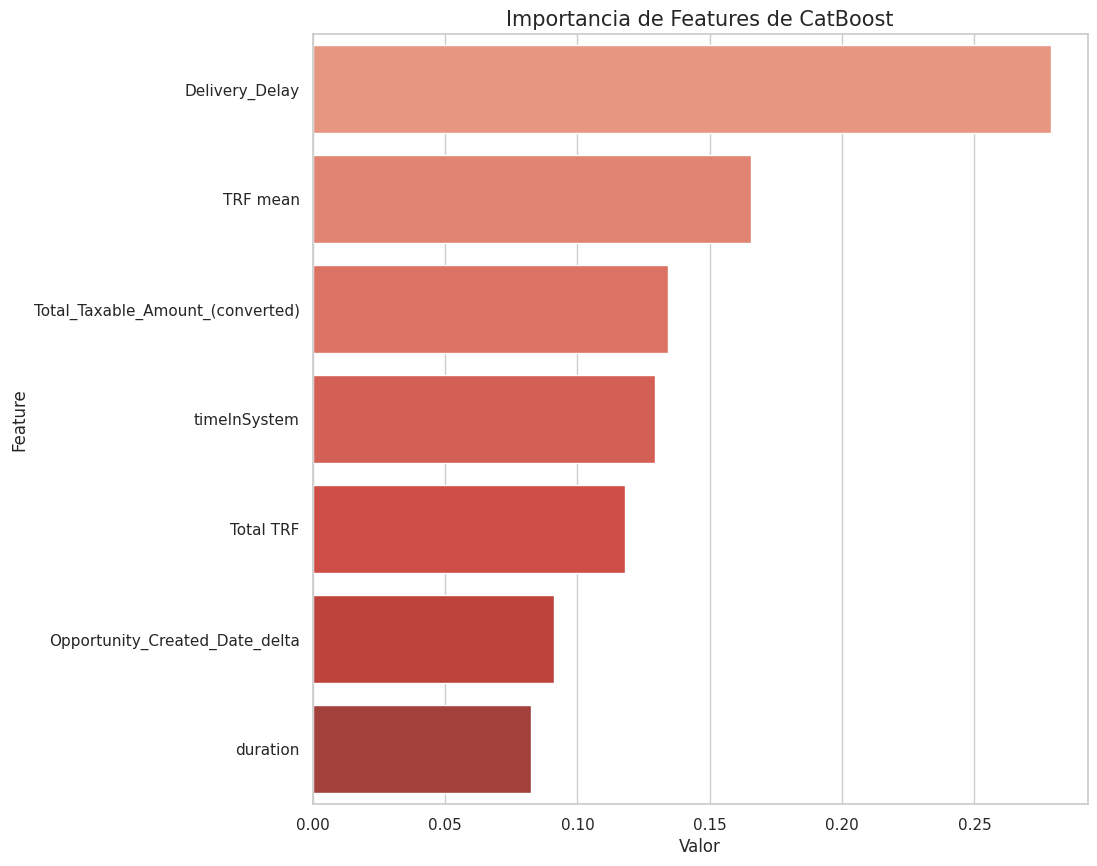

In [ ]:
# Feature importance Set reducido Random Forest
features = pd.DataFrame(index=X.columns)
features['imp'] = rf_model.feature_importances_
features = features.sort_values(['imp'], ascending = False)
features

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 10)
sns.set(style="whitegrid")

g = sns.barplot(y=features.index, x=features.imp, \
                palette=sns.color_palette("Reds_d", 10));

g.set_title('Importancia de Features de CatBoost', fontsize=15);
g.set_xlabel('Valor');
g.set_ylabel('Feature');

## LightGBM

In [ ]:
import lightgbm as lgb
import re

In [ ]:
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
toTest = toTest.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))



lgb_train = lgb.Dataset(X, y)

params = {
    'objective': 'regression',
    'metric': 'binary_logloss',
    'max_depth': 25,
    'learning_rate': 0.05,
    'feature_fraction': 1,
    'num_leaves': 15
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200)

preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
Logloss = log_loss(y_test, preds)
print("Log Loss: %f" % (Logloss))

Log Loss: 0.344101


In [ ]:
predsLGBM = gbm.predict(toTest)

predict_lgbm = pd.DataFrame(data=ids)

predict_df["Target"] = predsLGBM

predict_df.head()

,Opportunity_ID,Target
423,11223,0.795781
422,11222,0.788633
424,11224,0.799863
425,11225,0.561752
426,11226,0.645272


In [ ]:
predict_df.to_csv("resultadoLGBM.csv",index=False) 

## Redes Neuronales

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Flatten, Bidirectional, MaxPooling1D, Conv1D

In [ ]:
#Modelo con capas dense + Maxpooling
print(X_train.shape)
model1 = Sequential()
model1.add(Dense(1000,activation='sigmoid',input_shape=(20,)))
model1.add(Dropout(0.2))
model1.add(Dense(700,activation='sigmoid'))
model1.add(tf.keras.layers.Reshape((700,1)))
model1.add(MaxPooling1D(pool_size=8, padding='same', data_format='channels_first'))
model1.add(Flatten())
model1.add(tf.keras.layers.Reshape(( 700,1)))
model1.add(MaxPooling1D(pool_size=3, padding='same', data_format='channels_first'))
model1.add(Flatten())
model1.add(Dense(200,activation='sigmoid'))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss ='binary_crossentropy', optimizer='rmsprop',metrics = ['accuracy'])
print(model1.summary())
model1.build()

In [ ]:
#Modelo con capas Dense + LSTM + Maxpooling
model2 = Sequential()
model2.add(Dense(1000,activation='sigmoid',input_shape=(20,)))
model2.add(Dropout(0.2))
model2.add(Dense(700,activation='sigmoid'))
model2.add(tf.keras.layers.Reshape((700,1)))
model2.add(MaxPooling1D(pool_size=8, padding='same', data_format='channels_first'))
model2.add(Flatten())
model2.add(tf.keras.layers.Reshape(( 700,1)))
model2.add(MaxPooling1D(pool_size=3, padding='same', data_format='channels_first'))
model2.add(Flatten())
model2.add(Dense(200,activation='sigmoid'))
model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss ='binary_crossentropy', optimizer='rmsprop',metrics = ['accuracy'])
print(model2.summary())
model2.build()

In [ ]:
#Modelo con capas Dense + Conv1D
model3 = Sequential()
model3.add(Dense(1000,activation='sigmoid',input_shape=(20,)))
model3.add(Dropout(0.2))
model3.add(Dense(500,activation='sigmoid'))
model3.add(Flatten())
model3.add(tf.keras.layers.Reshape(( 1,500)))
model3.add(Conv1D(1000, 2, 10, padding='same', activation='relu'))
model3.add(Flatten())
model3.add(Dense(500,activation='sigmoid'))
model3.add(Dropout(0.2))
model3.add(tf.keras.layers.Reshape((1,500)))
model3.add(MaxPooling1D(pool_size=10, padding='same', data_format='channels_last'))
model3.add(Flatten())
model3.add(Dropout(0.2))
model3.add(Dense(1,activation='sigmoid'))
model3.compile(loss ='binary_crossentropy', optimizer='rmsprop',metrics = ['accuracy'])
print(model3.summary())
model3.build()

In [ ]:
batch_size = 20

In [ ]:
minloss = 16
minep = 0
for ep in (5, 50, 5):
    model.fit(X_train,y_train, batch_size = batch_size, epochs = ep, verbose=0)
    pred = model.predict(X_test).tolist()
    loss = log_loss(y_test, pred)
    print("epochs: ", ep, "loss:", loss)
    if (loss < minloss):
        minloss = loss
        minep = ep

In [ ]:
model1.fit(X,y, batch_size = batch_size, epochs = ep)
#model2.fit(X,y, batch_size = batch_size, epochs = ep)
#model3.fit(X,y, batch_size = batch_size, epochs = ep)

In [ ]:
preds = model.predict(toTest)
ops = ids
res = pd.DataFrame()
res["Opportunity_ID"] = ops
res["Target"] = preds

res.to_csv("submit.csv", index=False)